In [ ]:
# Assignment 9
# Group 20
from random import seed, randint

seed(902987817)
random_no = randint(1,100)
print(random_no)

# Random Number Generated: 35, corresponding to BNP PARIBAS USA, INC.

In [ ]:
#section 2 - Holdings
import yfinance as yf

bnp = yf.Ticker('BNP.PA')
bnp.major_holders

In [ ]:
#Section 2 - Transactions
from bs4 import BeautifulSoup
import pandas as pd
import requests

url = 'https://finance.yahoo.com/quote/BNP.PA/insider-transactions?p=BNP.PA'

r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc, features='html.parser')

table = soup.find('table', attrs={'class':'subs noBorders evenRows'})
table_rows = soup.findAll('tr')

list1 = []
for tr in table_rows:
    td = tr.findAll('td')
    row = [tr.text for tr in td]
    list1.append(row)

df=pd.DataFrame(list1)   

In [ ]:
#there is no insider transaction in past few years
df

In [ ]:
# Section 3
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas_datareader.data as web
import mplfinance as mpf
from sklearn.linear_model import LinearRegression as lm 

#### 1. Stock Return, Beta, & Volatility

In [ ]:
# Plot price series for the last 6-months
bnp_paribas = pd.read_csv("BNPQY.csv")
bnp_paribas.set_index(pd.to_datetime(bnp_paribas["Date"]), inplace=True)
mpf.plot(bnp_paribas.loc["2021-06":],type = "candle", style = "yahoo", volume = True, title = "BNP Paribas Last 6 Months Daily Prices")

In [ ]:
# Import Fama to get rf
fama = pd.read_csv("fama_daily.CSV", skiprows=3)
fama.columns = ["DATE", "MKT_RF", "SMB", "HML", "RF"]
fama = fama.iloc[:25084,:]
fama.set_index(pd.to_datetime(fama["DATE"]), inplace=True)
fama = fama[["MKT_RF", "SMB", "HML", "RF"]]

# Import Prices from yahoo
# bnp = web.DataReader("BNPQY", "yahoo", start="2001-01-01")
bnp = pd.read_csv("BNPQY.csv")
# Calculate returns as percent change of adjusted close
bnp["RET"] = bnp["Adj Close"].pct_change()
bnp["DATE"] = bnp["Date"]
bnp.set_index(pd.to_datetime(bnp["DATE"]), inplace=True)
bnp = bnp[["Adj Close", "RET"]]
bnp.columns = ["PRC", "RET"]

# Merge and calculate cumulative returns
data = pd.merge(bnp, fama, on="DATE", how="left")
data = data[["PRC", "RET", "MKT_RF", "RF"]]
data["RF"] = data["RF"] / 100
data["EXRET"] = data["RET"] - data["RF"]
data["MKT_RF"] = data["MKT_RF"] / 100
data["CRET"] = ((data["RET"] + 1).cumprod() - 1)
data["CEXRET"] = ((data["EXRET"] + 1).cumprod() - 1)
data.head()

In [ ]:
# Plot Cumulative and Excess Cumulative Returns
ax = (data[["CRET", "CEXRET"]] * 100).plot(figsize = (10,6), title = "BNP Paribas Cumulative Daily Returns/Excess Returns since 6/5/2003")
ax.legend(labels = ["Cumulative Returns", "Cumulative Excess Returns"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [ ]:
# Volatility
# Standard Deviation
vol = data.groupby(pd.Grouper(freq="M"))["EXRET"].std().reset_index()
vol.set_index(vol["DATE"], inplace = True)
vol = vol.drop("DATE", axis = 1)
vol.columns = ["M_VOL"]
vol = vol.resample("1D").ffill()

data = data.merge(vol, on = "DATE", how = "left")
data.head()

In [ ]:
# Covariance
cov = data.groupby(pd.Grouper(freq="M"))["EXRET", "MKT_RF"].cov().reset_index()
cov.set_index(cov["DATE"], inplace = True)
cov = cov.drop("DATE", axis = 1)
cov = cov[(cov["level_1"] == "EXRET")]["MKT_RF"].reset_index(0)
cov.set_index(cov["DATE"], inplace = True)
cov = cov.drop("DATE", axis = 1)
cov.columns = ["RETCOV"]
cov = cov.resample("1D").ffill()
data = data.merge(cov, on = "DATE", how = "left")
data.head()

In [ ]:
# Beta
data["BETA"] = data["RETCOV"] / data["M_VOL"]
data["BETA"].mean()

In [ ]:
# All data regression for beta
df = data[["MKT_RF", "EXRET"]]
df = df.dropna()
X = np.array(df["MKT_RF"]).reshape((-1,1))
y = np.array(df["EXRET"])
model = lm().fit(X = X, y = y)

print(f"Beta (all data, daily) from regression: {model.coef_[0]}")

In [ ]:
# 5 Year beta
df = data[["MKT_RF", "EXRET"]]
df = df.loc["2016-11":,:]
df = df.dropna()
X = np.array(df["MKT_RF"]).reshape((-1,1))
y = np.array(df["EXRET"])
model = lm().fit(X = X, y = y)

print(f"Beta (5 year, daily) from regression: {model.coef_[0]}")

In [ ]:
# TTM Monthly Beta
df = data[["MKT_RF", "EXRET"]]
df = df.loc["2020-11":,:]
df = df.dropna()
X = np.array(df["MKT_RF"]).reshape((-1,1))
y = np.array(df["EXRET"])
model = lm().fit(X = X, y = y)

print(f"Beta (TTM, daily) from regression: {model.coef_[0]}")

In [ ]:
df = data[["MKT_RF", "EXRET"]]
df = df.resample('M').agg(lambda x: (x + 1).prod() - 1)
df = df.dropna()
X = np.array(df["MKT_RF"]).reshape((-1,1))
y = np.array(df["EXRET"])
model = lm().fit(X = X, y = y)

print(f"Beta (all data, monthly) from regression: {model.coef_[0]}")

In [ ]:
df = data[["MKT_RF", "EXRET"]]
df = df.resample('M').agg(lambda x: (x + 1).prod() - 1)
df = df.loc["2016-11":,:]
df = df.dropna()
X = np.array(df["MKT_RF"]).reshape((-1,1))
y = np.array(df["EXRET"])
model = lm().fit(X = X, y = y)

print(f"Beta (5 year, monthly) from regression: {model.coef_[0]}")

In [ ]:
df = data[["MKT_RF", "EXRET"]]
df = df.resample('M').agg(lambda x: (x + 1).prod() - 1)
df = df.loc["2020-11":,:]
df = df.dropna()
X = np.array(df["MKT_RF"]).reshape((-1,1))
y = np.array(df["EXRET"])
model = lm().fit(X = X, y = y)

print(f"Beta (TTM, monthly) from regression: {model.coef_[0]}")

In [ ]:
df = data[["MKT_RF", "EXRET"]]
mon = df.resample('M').agg(lambda x: (x + 1).prod() - 1)
yr = df.resample('Y').agg(lambda x: (x + 1).prod() - 1)

In [ ]:
alldf = df.std()
fyrdf = df.loc["2016-11":,:].std()
ttmdf = df.loc["2020-11":,:].std()
print(f"Whole Period Daily Market Volatility: {alldf[0]} and BNP Volatility: {alldf[1]}.")
print(f"Last 5 Year Daily Market Volatility: {fyrdf[0]} and BNP Volatility: {fyrdf[1]}.")
print(f"TTM Daily Market Volatility: {ttmdf[0]} and BNP Volatility: {ttmdf[1]}.")

In [ ]:
allmon = mon.std()
fyrmon = mon.loc["2016-11":,:].std()
ttmmon = mon.loc["2020-11":,:].std()
print(f"Whole Period Monthly Market Volatility: {allmon[0]} and BNP Volatility: {allmon[1]}.")
print(f"Last 5 Year Monthly Market Volatility: {fyrmon[0]} and BNP Volatility: {fyrmon[1]}.")
print(f"TTM Monthly Market Volatility: {ttmmon[0]} and BNP Volatility: {ttmmon[1]}.")

In [ ]:
allyr = yr.std()
fyryr = yr.loc["2016-11":,:].std()
ttmyr = yr.loc["2020-11":,:].std()
print(f"Whole Period Yearly Market Volatility: {allyr[0]} and BNP Volatility: {allyr[1]}.")
print(f"Last 5 Year Yearly Market Volatility: {fyryr[0]} and BNP Volatility: {fyryr[1]}.")
print(f"TTM Yearly Market Volatility: {ttmyr[0]} and BNP Volatility: {ttmyr[1]}.")

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.28.0

pandas    : 1.3.3
numpy     : 1.6.2
matplotlib: 3.4.3

Compiler    : MSC v.1927 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



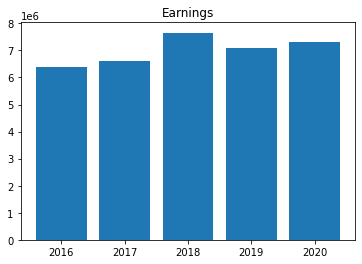

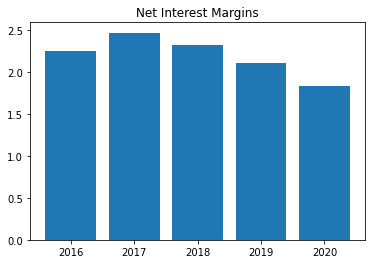

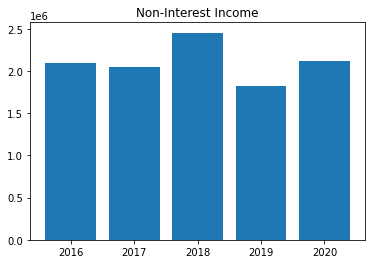

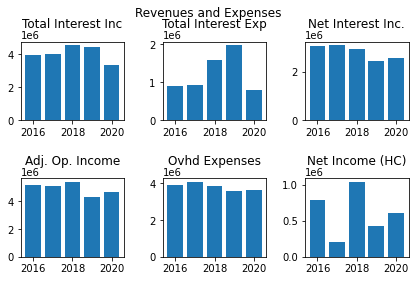

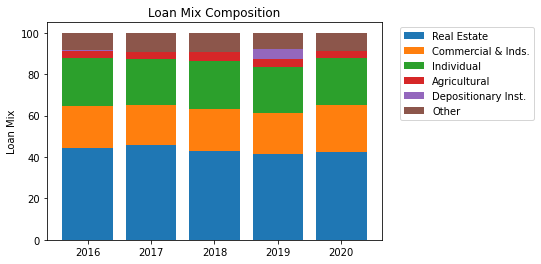

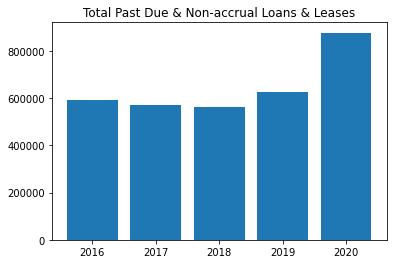

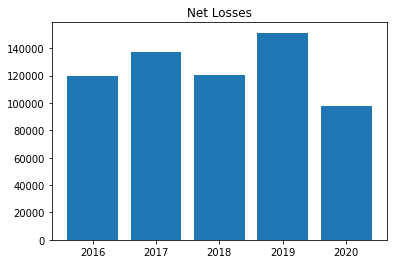

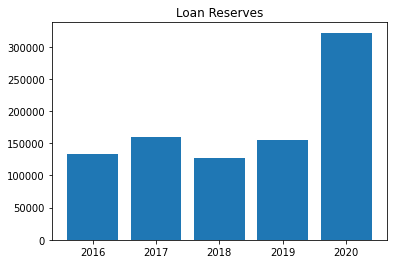

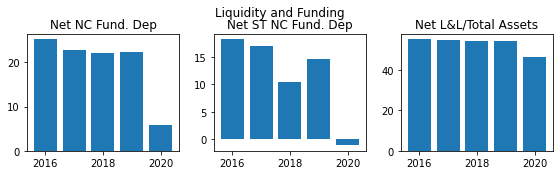

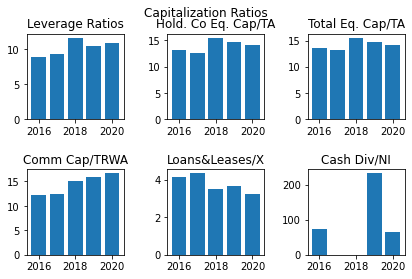

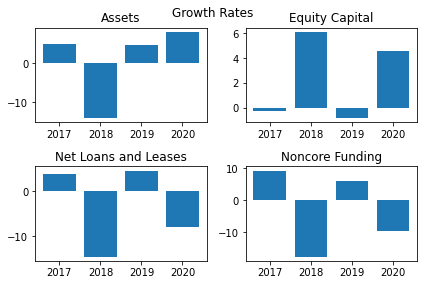

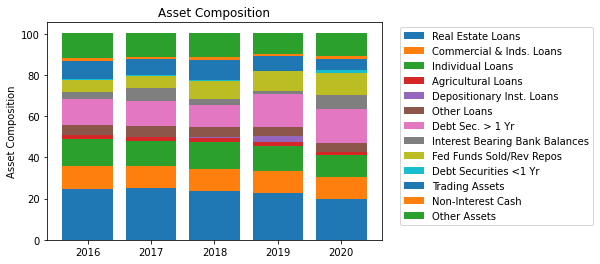

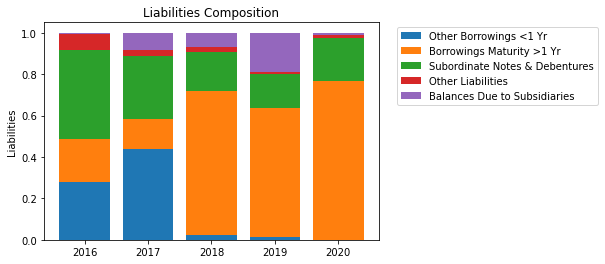

In [18]:
# Section 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %load_ext watermark
# %watermark -v -m -p pandas,numpy,matplotlib

csv_path = "BHCPR_1575569_20201231.csv"
dates = np.array([2020,2019,2018,2017,2016])

performance_report = np.array(pd.read_csv(csv_path))

# Earnings
retained_earnings = performance_report[6116:6121,2].astype(float)

plt.bar(dates, retained_earnings)
plt.title("Earnings")
plt.show()

# Net Interest Margins
net_int_inc_over_avg_earn_assets = performance_report[513:518,2].astype(float)

plt.bar(dates, net_int_inc_over_avg_earn_assets)
plt.title("Net Interest Margins")
plt.show()

# Non-Interest Income
nonint_inc = performance_report[914:919,2].astype(float)

plt.bar(dates, nonint_inc)
plt.title("Non-Interest Income")
plt.show()

# Revenues and Expenses
total_int_inc = performance_report[814:819,2].astype(float)
total_int_exp = performance_report[909:914,2].astype(float)
net_int_inc = performance_report[824:829,2].astype(float)
adj_op_inc = performance_report[849:854,2].astype(float)
ovh_exp = performance_report[919:924,2].astype(float)
net_inc_hc = performance_report[1027:1032,2].astype(float)

fig, rev_and_exp_axs = plt.subplots(2,3,squeeze=False) # mark the position of the subplot
rev_and_exp_axs[0,0].bar(dates, total_int_inc)
rev_and_exp_axs[0,0].set_title('Total Interest Inc',y = 1.1)
rev_and_exp_axs[0,1].bar(dates, total_int_exp)
rev_and_exp_axs[0,1].set_title('Total Interest Exp',y = 1.1)
rev_and_exp_axs[0,2].bar(dates, net_int_inc)
rev_and_exp_axs[0,2].set_title('Net Interest Inc.',y = 1.1)
rev_and_exp_axs[1,0].bar(dates, adj_op_inc)
rev_and_exp_axs[1,0].set_title('Adj. Op. Income',y = 1.1)
rev_and_exp_axs[1,1].bar(dates, ovh_exp)
rev_and_exp_axs[1,1].set_title('Ovhd Expenses',y = 1.1)
rev_and_exp_axs[1,2].bar(dates, net_inc_hc)
rev_and_exp_axs[1,2].set_title('Net Income (HC)',y = 1.1)
fig.tight_layout(pad=1.5)
fig.suptitle("Revenues and Expenses")

# Loan Mix
RE_loans = performance_report[2656:2661,2].astype(float)
commercial_and_inds_loans = performance_report[2682:2687,2].astype(float)
indiv_loans = performance_report[2513:2518,2].astype(float)
agric_loans = performance_report[2552:2557,2].astype(float)
dep_inst_loans = performance_report[2669:2674,2].astype(float)
other_loans = performance_report[2526:2531,2].astype(float)

fig, loan_mix_axs = plt.subplots()
loan_mix_axs.bar(dates, RE_loans, label = "Real Estate")
loan_mix_axs.bar(dates, commercial_and_inds_loans,label="Commercial & Inds.",bottom = RE_loans)
loan_mix_axs.bar(dates, indiv_loans,label="Individual",bottom = RE_loans+commercial_and_inds_loans)
loan_mix_axs.bar(dates, agric_loans,label="Agricultural",bottom = RE_loans+commercial_and_inds_loans+indiv_loans)
loan_mix_axs.bar(dates, dep_inst_loans,label="Depositionary Inst.",bottom = RE_loans+commercial_and_inds_loans+indiv_loans+agric_loans)
loan_mix_axs.bar(dates, other_loans,label="Other",bottom = RE_loans+commercial_and_inds_loans+indiv_loans+agric_loans+dep_inst_loans)
loan_mix_axs.set_ylabel("Loan Mix")
loan_mix_axs.legend(bbox_to_anchor=(1.04,1))
loan_mix_axs.set_title("Loan Mix Composition")
plt.show()

# Past Due and Losses
past_due = performance_report[4935:4940,2].astype(float)
losses = performance_report[4825:4830,2].astype(float)

plt.bar(dates, past_due)
plt.title("Total Past Due & Non-accrual Loans & Leases")
plt.show()

plt.bar(dates, losses)
plt.title("Net Losses")
plt.show()

# Loan Reserves (Provision for loan and lease losses)
loan_reserves = performance_report[927:932,2].astype(float)

plt.bar(dates, loan_reserves)
plt.title("Loan Reserves")
plt.show()

# Liquidity and Funding
net_noncore_funding_dep = performance_report[689:694,2].astype(float)
net_short_term_noncore_fund_dep = performance_report[791:796,2].astype(float)
net_loans_leases_div_total_assets = performance_report[715:720,2].astype(float)

fig, liq_and_funding_axs = plt.subplots(1,3,figsize=(8,2.5)) # mark the position of the subplot
liq_and_funding_axs[0].bar(dates, net_noncore_funding_dep)
liq_and_funding_axs[0].set_title('Net NC Fund. Dep')
liq_and_funding_axs[1].bar(dates, net_short_term_noncore_fund_dep)
liq_and_funding_axs[1].set_title('Net ST NC Fund. Dep')
liq_and_funding_axs[2].bar(dates, net_loans_leases_div_total_assets)
liq_and_funding_axs[2].set_title('Net L&L/Total Assets')
fig.tight_layout(pad=1.5)
fig.suptitle("Liquidity and Funding")

# Capitalization Ratios
leverage_ratios = performance_report[778:783,2].astype(float)
hold_comp_eq_cap_over_tot_assets = performance_report[752:757,2].astype(float)
tot_eq_cap_over_tot_assets = performance_report[1014:1019,2].astype(float)
comm_eq_cap_over_total_rw_assets = performance_report[1822:1827,2].astype(float)
net_loans_and_leases_over_eq_cap = performance_report[765:770,2].astype(float)
cash_div_over_ni = performance_report[611:616,2].astype(float)
cash_div_over_ni = cash_div_over_ni.astype(float)

fig, cap_rates_axs = plt.subplots(2,3,squeeze=False) # mark the position of the subplot
cap_rates_axs[0,0].bar(dates, leverage_ratios)
cap_rates_axs[0,0].set_title('Leverage Ratios')
cap_rates_axs[0,1].bar(dates, hold_comp_eq_cap_over_tot_assets)
cap_rates_axs[0,1].set_title('Hold. Co Eq. Cap/TA')
cap_rates_axs[0,2].bar(dates, tot_eq_cap_over_tot_assets)
cap_rates_axs[0,2].set_title('Total Eq. Cap/TA')
cap_rates_axs[1,0].bar(dates, comm_eq_cap_over_total_rw_assets)
cap_rates_axs[1,0].set_title('Comm Cap/TRWA')
cap_rates_axs[1,1].bar(dates, net_loans_and_leases_over_eq_cap)
cap_rates_axs[1,1].set_title('Loans&Leases/X')
cap_rates_axs[1,2].bar(dates, cash_div_over_ni)
cap_rates_axs[1,2].set_title('Cash Div/NI')
fig.tight_layout(pad=1.7)
fig.suptitle("Capitalization Ratios")

# Growth Rates
assets = performance_report[600:604,2].astype(float)
eq_capital = performance_report[741:745,2].astype(float)
net_loans_leases = performance_report[578:582,2].astype(float)
non_core_funding = performance_report[589:593,2].astype(float)

fig, growth_rates_axs = plt.subplots(2,2,squeeze=False)
growth_rates_axs[0,0].bar(dates[0:4], assets)
growth_rates_axs[0,0].set_title("Assets")
growth_rates_axs[0,1].bar(dates[0:4], eq_capital)
growth_rates_axs[0,1].set_title("Equity Capital")
growth_rates_axs[1,0].bar(dates[0:4], net_loans_leases)
growth_rates_axs[1,0].set_title("Net Loans and Leases")
growth_rates_axs[1,1].bar(dates[0:4], non_core_funding)
growth_rates_axs[1,1].set_title("Noncore Funding")
fig.tight_layout(pad=1.1)
fig.suptitle("Growth Rates")

# Asset Composition
RE_loans = performance_report[2331:2336,2].astype(float)
commercial_and_inds_loans = performance_report[2344:2349,2].astype(float)
indiv_loans = performance_report[2357:2362,2].astype(float)
dep_inst_loans = performance_report[2370:2375,2].astype(float)
agric_loans = performance_report[2825:2830,2].astype(float)
other_loans = performance_report[2383:2388,2].astype(float)
debt_sec_over_1_year = performance_report[2578:2583,2].astype(float)
int_bear_bank_balances = performance_report[2318:2323,2].astype(float)
fed_funds_rev_repos = performance_report[2487:2492,2].astype(float)
debt_sec_less_1_year = performance_report[2643:2648,2].astype(float)
trading_assets = performance_report[2500:2505,2].astype(float)
non_int_cash = performance_report[2799:2804,2].astype(float)
other_assets = performance_report[2396:2401,2].astype(float)

fig, asset_mix_axs = plt.subplots()
asset_mix_axs.bar(dates, RE_loans, label = "Real Estate Loans")
asset_mix_axs.bar(dates, commercial_and_inds_loans,label="Commercial & Inds. Loans",bottom = RE_loans)
asset_mix_axs.bar(dates, indiv_loans,label="Individual Loans",bottom = RE_loans+commercial_and_inds_loans)
asset_mix_axs.bar(dates, agric_loans,label="Agricultural Loans",bottom = RE_loans+commercial_and_inds_loans+indiv_loans)
asset_mix_axs.bar(dates, dep_inst_loans,label="Depositionary Inst. Loans",bottom = RE_loans+commercial_and_inds_loans+indiv_loans+agric_loans)
asset_mix_axs.bar(dates, other_loans,label="Other Loans",bottom = RE_loans+commercial_and_inds_loans+indiv_loans+agric_loans+dep_inst_loans)
bottom_temp = RE_loans+commercial_and_inds_loans+indiv_loans+agric_loans+dep_inst_loans+other_loans
asset_mix_axs.bar(dates, debt_sec_over_1_year,label="Debt Sec. > 1 Yr",bottom = bottom_temp)
bottom_temp = bottom_temp+debt_sec_over_1_year
asset_mix_axs.bar(dates, int_bear_bank_balances,label="Interest Bearing Bank Balances",bottom = bottom_temp)
bottom_temp = bottom_temp+int_bear_bank_balances
asset_mix_axs.bar(dates, fed_funds_rev_repos,label="Fed Funds Sold/Rev Repos",bottom = bottom_temp)
bottom_temp = bottom_temp+fed_funds_rev_repos
asset_mix_axs.bar(dates, debt_sec_less_1_year,label="Debt Securities <1 Yr",bottom = bottom_temp)
bottom_temp = bottom_temp+debt_sec_less_1_year
asset_mix_axs.bar(dates, trading_assets,label="Trading Assets",bottom = bottom_temp)
bottom_temp = bottom_temp+trading_assets
asset_mix_axs.bar(dates, non_int_cash,label="Non-Interest Cash",bottom = bottom_temp)
bottom_temp = bottom_temp+non_int_cash
asset_mix_axs.bar(dates, other_assets,label="Other Assets",bottom = bottom_temp)

asset_mix_axs.set_ylabel("Asset Composition")
asset_mix_axs.legend(bbox_to_anchor=(1.04,1))
asset_mix_axs.set_title("Asset Composition")
plt.show()

# Liability Composition
other_borrowing_less_1_yr = performance_report[6086:6091,2].astype(float)
borrowings_mat_over_1_yr = performance_report[6011:6016,2].astype(float)
sub_notes_and_debentures = performance_report[6196:6201,2].astype(float)
other_liabs = performance_report[6091:6096,2].astype(float)
bal_due_subsidiaries = performance_report[6191:6196,2].astype(float)
total_liab = performance_report[6141:6146,2].astype(float)

other_borrowing_less_1_yr = other_borrowing_less_1_yr/total_liab
borrowings_mat_over_1_yr = borrowings_mat_over_1_yr/total_liab
sub_notes_and_debentures = sub_notes_and_debentures/total_liab
other_liabs = other_liabs/total_liab
bal_due_subsidiaries = bal_due_subsidiaries/total_liab

fig, liab_comp_axs = plt.subplots()
liab_comp_axs.bar(dates, other_borrowing_less_1_yr, label = "Other Borrowings <1 Yr")
liab_comp_axs.bar(dates, borrowings_mat_over_1_yr,label="Borrowings Maturity >1 Yr",bottom = other_borrowing_less_1_yr)
liab_comp_axs.bar(dates, sub_notes_and_debentures,label="Subordinate Notes & Debentures",bottom = other_borrowing_less_1_yr+borrowings_mat_over_1_yr)
liab_comp_axs.bar(dates, other_liabs,label="Other Liabilities",bottom = other_borrowing_less_1_yr+borrowings_mat_over_1_yr+sub_notes_and_debentures)
liab_comp_axs.bar(dates, bal_due_subsidiaries,label="Balances Due to Subsidiaries",bottom = other_borrowing_less_1_yr+borrowings_mat_over_1_yr+sub_notes_and_debentures+other_liabs)
liab_comp_axs.set_ylabel("Liabilities")
liab_comp_axs.legend(bbox_to_anchor=(1.04,1))
liab_comp_axs.set_title("Liabilities Composition")
plt.show()

# Maturity Gap
# Interest Rate Bearing Assets

# Interest Rate Bearing Liabilities 

In [ ]:
#section 6
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = "BHCPR_1575569_20201231.csv"
dates = np.array([2020,2019,2018,2017,2016])

performance_report = np.array(pd.read_csv(csv_path))

#off-balance componenets
loan_commits = performance_report[3847:3852,2].astype(float)
commit_secured_real_estate = performance_report[3842:3847,2].astype(float)
commit_unsecured_real_estate = performance_report[3663:3668,2].astype(float)
credit_card_lines = performance_report[7651:7656,2].astype(float)
standby_letter = performance_report[3681:3686,2].astype(float)
comm_similar_letter = performance_report[3638:3643,2].astype(float)
securities_lent = performance_report[3643:3648,2].astype(float)
credit_derivative_subinvest_grade = performance_report[7620:7625,2].astype(float)

#off-balance total
#off_balance_total = loan_commits + commit_secured_real_estate + commit_unsecured_real_estate + credit_card_lines + standby_letter + comm_similar_letter + securities_lent + credit_derivative_subinvest_grade
off = pd.DataFrame({'Year' : dates,
                    'Loan Commitments': loan_commits,
                    'Commit: Secured commercial real estate': commit_secured_real_estate,
                   'Commit: Unsecured real estate': commit_unsecured_real_estate,
                    'Credit Card Lines': credit_card_lines,
                   'Standby letters of Credit': standby_letter,
                    'Commercial letters of credit': comm_similar_letter,
                   'Securities Lent': securities_lent,
                    'Credit Derivative - Subinvestment Grade': credit_derivative_subinvest_grade})
off.set_index(off['Year'], inplace=True)

#derivatives
total_derivative = performance_report[36:38,2].astype(float)
total_derivative1 = performance_report[7266:7269,2].astype(float)
total_derivative = np.append(total_derivative,total_derivative1)

#securitization activities
sa1 = performance_report[88:90,2].astype(float)
sa2 = performance_report[7728:7731,2].astype(float)
sec_act = np.append(sa1,sa2)

#capital level of assets
l1 = performance_report[218:220,2].astype(float)
l2 = performance_report[7947:7950,2].astype(float)
level1 = np.append(l1,l2)

l1 = performance_report[200:202,2].astype(float)
l2 = performance_report[7917:7920,2].astype(float)
level2 = np.append(l1,l2)

In [ ]:
#Section 6.1 - off balance sheet growth
plt.bar(dates, off_balance_total)
plt.title("Off-balance Sheet Growth")
plt.show()

In [ ]:
#Section 6.2
#2020

# fig, ax = plt.subplots(1,5, figsize=(10, 6))

# for i in range(0,4):
#     ax.pie(off.iloc[i, 1:8], labels=off.columns[1:8], startangle=30)
#     ax.set_title(off.index[i])

# #fig.subplots_adjust(wspace=.2)


plt.pie(off.iloc[0, 1:8], labels = off.columns[1:8])
plt.title(off.index[0])
plt.show()

In [ ]:
#section 6.3
plt.bar(dates, total_derivative)
plt.title("Derivative Usage")
plt.show()

In [ ]:
section 6.4
plt.bar(dates, sec_act)
plt.title("Securitization Activites")
plt.show()

In [ ]:
#section 6.5
plt.bar(dates, level1, label='Level 1')
plt.bar(dates, level2, bottom=level1, label='Level 2')
plt.title("Level of Assets")
plt.show()